### Question 3 : Time Series Analysis for Sales Forecasting

Can we develop a reliable time series model to forecast future sales volumes and identify 
seasonal patterns in the Brazilian e-commerce market?

In [10]:
# libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error


#### Data

In [15]:
orders = pd.read_csv('../Dataset/raw/olist_orders_dataset.csv', parse_dates=['order_purchase_timestamp'])

# Preview
orders.head()


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


#### EDA

In [16]:
# Extract  date 
orders['order_date'] = orders['order_purchase_timestamp'].dt.date

# Group by date and count orders
daily_orders = orders.groupby('order_date').size().rename("order_count")

# Convert index to datetime
daily_orders.index = pd.to_datetime(daily_orders.index)

# Sort by date
daily_orders = daily_orders.sort_index()

print(daily_orders.head())


order_date
2016-09-04    1
2016-09-05    1
2016-09-13    1
2016-09-15    1
2016-10-02    1
Name: order_count, dtype: int64


#### Visuals

Daily order volume

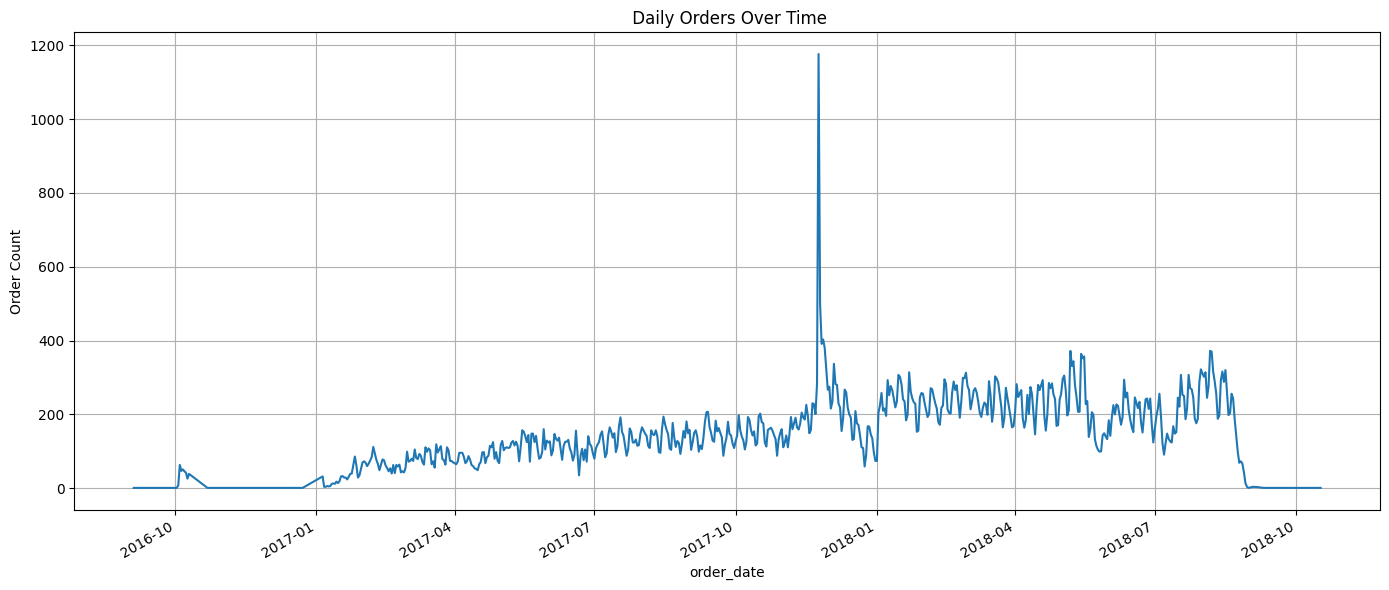

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
daily_orders.plot(title=' Daily Orders Over Time', ylabel='Order Count')
plt.grid(True)
plt.tight_layout()
plt.show()


Fully daily time series

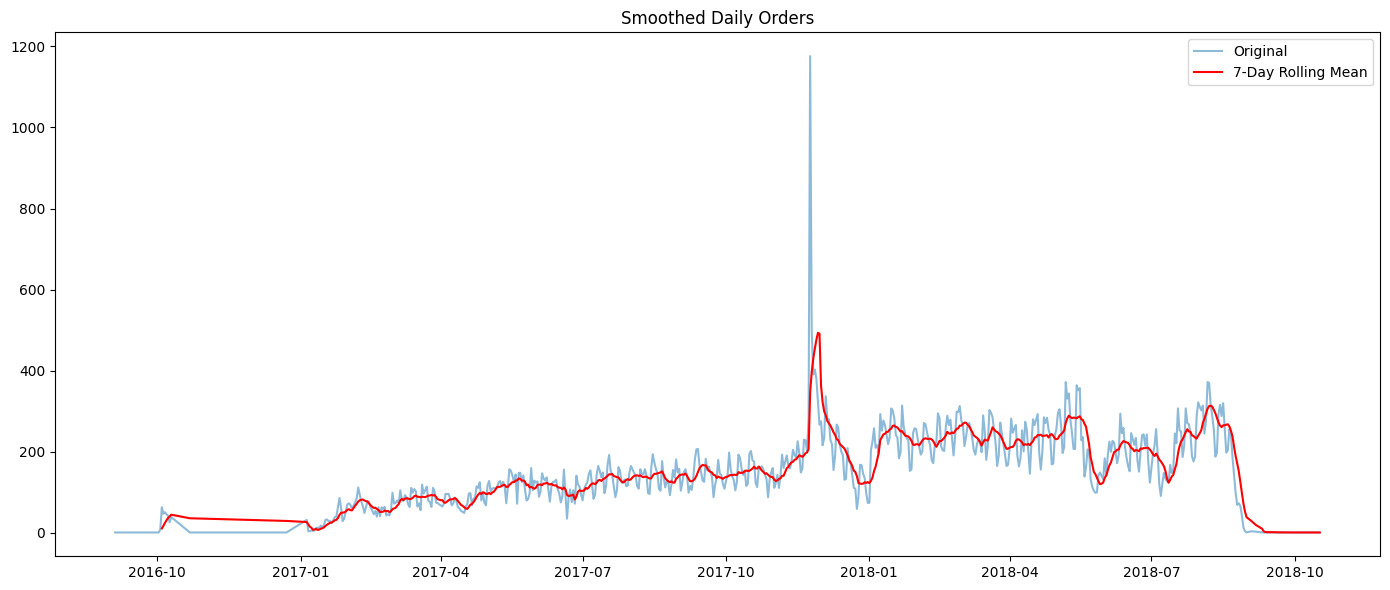

In [21]:
daily_orders_rolling = daily_orders.rolling(window=7).mean()

plt.figure(figsize=(14, 6))
plt.plot(daily_orders, alpha=0.5, label='Original')
plt.plot(daily_orders_rolling, color='red', label='7-Day Rolling Mean')
plt.title('Smoothed Daily Orders')
plt.legend()
plt.tight_layout()
plt.show()


Decomposing time series

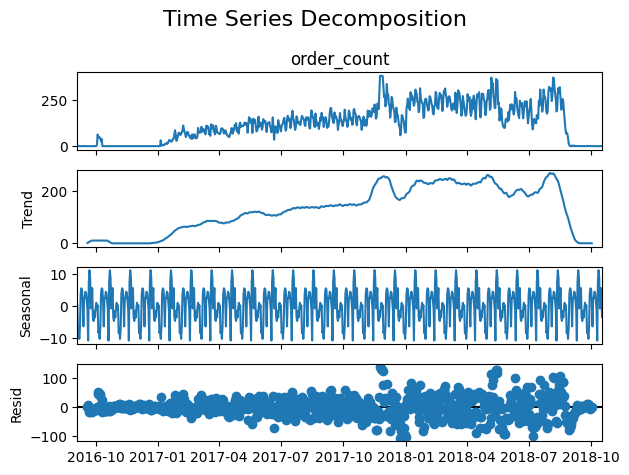

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Fill in missing days and clip extreme values
daily_filled = daily_orders.asfreq('D', fill_value=0)

# cap outliers (to remove the spike)
threshold = daily_filled.quantile(0.995)
daily_clean = daily_filled.clip(upper=threshold)

# Decompose the cleaned series 
decomposition = seasonal_decompose(daily_clean, model='additive', period=30)
decomposition.plot()

plt.suptitle("Time Series Decomposition", fontsize=16)
plt.tight_layout()
plt.show()


#### Forecasting

In [29]:
# train-test split

# 700 days - 60 days
train = daily_clean[:'2018-07-31']
test = daily_clean['2018-08-01':]


print(f"Train: {train.shape}, Test: {test.shape}")


Train: (696,), Test: (78,)


In [30]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Basic SARIMA model: (p,d,q) x (P,D,Q,s) with weekly seasonality (s=7)
model = SARIMAX(train,
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 7),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()
print(results.summary())


                                     SARIMAX Results                                     
Dep. Variable:                       order_count   No. Observations:                  696
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -3142.614
Date:                           Wed, 30 Apr 2025   AIC                           6295.228
Time:                                   14:53:05   BIC                           6317.831
Sample:                               09-04-2016   HQIC                          6303.977
                                    - 07-31-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7791      0.019     40.735      0.000       0.742       0.817
ma.L1         -0.9867      0.008   -130.552

### Forecast & Plot

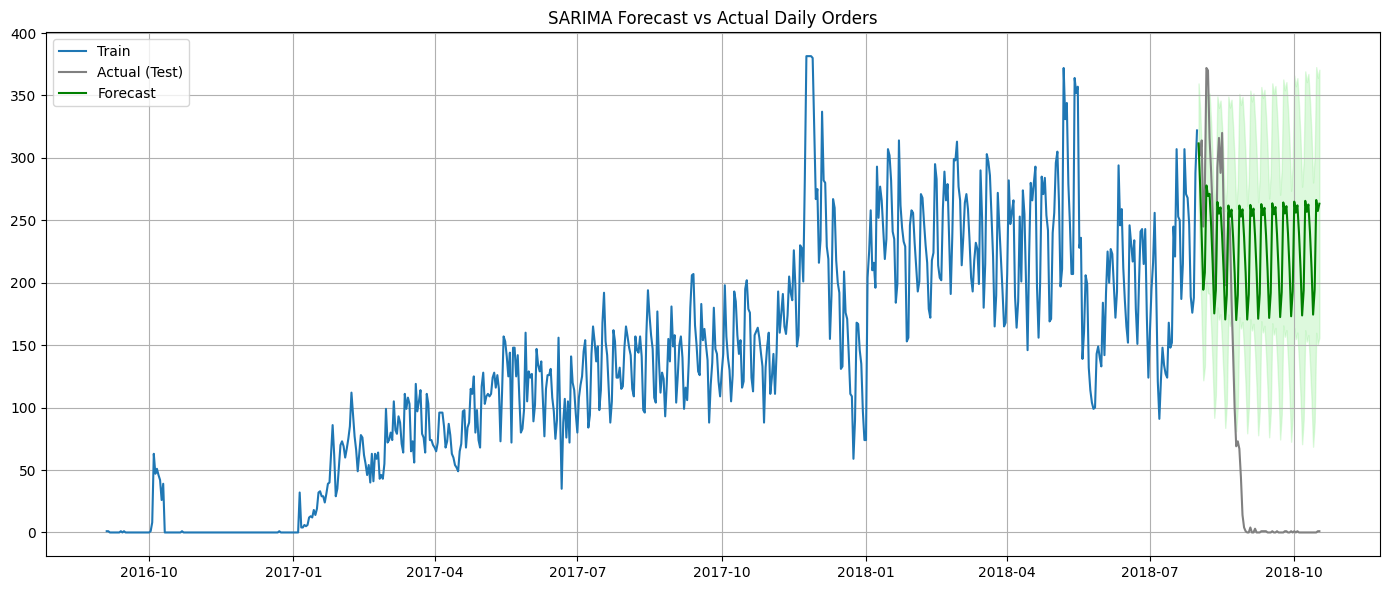

In [31]:

forecast = results.get_forecast(steps=len(test))
predicted = forecast.predicted_mean
conf_int = forecast.conf_int()

plt.figure(figsize=(14, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Actual (Test)', color='gray')
plt.plot(predicted, label='Forecast', color='green')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                 color='lightgreen', alpha=0.3)
plt.title('SARIMA Forecast vs Actual Daily Orders')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Evaluation



In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test, predicted)
mse = mean_squared_error(test, predicted)
rmse = mse ** 0.5

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 168.49
RMSE: 190.56
